In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels import regression
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [72]:
prior = 2015
post_1 = prior + 1
post_2 = post_1 + 1
post_3 = post_2 + 1

ben = 'D:/data/input/index/returns_{}/SPY.csv'.format(prior)
ben_1 = 'D:/data/input/index/returns_{}/SPY.csv'.format(post_1)
ben_2 = 'D:/data/input/index/returns_{}/SPY.csv'.format(post_2)
ben_3 = 'D:/data/input/index/returns_{}/SPY.csv'.format(post_3)


benchmark_1 = pd.read_csv(ben_1)
benchmark_1['Date'] = pd.to_datetime(benchmark_1['Date'])

benchmark_2 = pd.read_csv(ben_2)
benchmark_2['Date'] = pd.to_datetime(benchmark_2['Date'])

benchmark_3 = pd.read_csv(ben_3)
benchmark_3 = benchmark_3[benchmark_3['week_num']<=28]
benchmark_3['Date'] = pd.to_datetime(benchmark_3['Date'])

benchmark = pd.Series()
for b in [benchmark_1,benchmark_2,benchmark_3]:
    benchmark = pd.concat([benchmark,b],ignore_index=True)


mm =  list(benchmark['next_week_return'])
mm.insert(0,0)
mm = pd.Series(mm)

idx = list(benchmark['Date'])
new_date = pd.to_datetime('20160103')
idx.insert(0,new_date)
idx = pd.Series(idx)
len(mm)

C:\Users\acer\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



133

In [63]:
def filename(base_dir,factor,car_num,topic_num):
    name = base_dir +factor+'/'+str(car_num)+'_'+str(topic_num)+factor+'_return_data.csv'
    return name


def filename_k(root_dir,car_num,topic_num,factor):
    name = root_dir+'{}_car_{}_topics_{}_combine.csv'.format(car_num,topic_num,factor)
    return name


def combine_df(root_dir,prior_post_pairs,car_topic_pairs,factor):
    combine = pd.Series()
    for j in range(len(prior_post_pairs)):
        prior,post = prior_post_pairs[j]
        base_dir = root_dir + '{}-{}/'.format(prior,post)
    
        car_num,topic_num = car_topic_pairs[j]
        file = filename(base_dir,factor,car_num,topic_num)
        df = pd.read_csv(file)
        
        combine = pd.concat([combine,df], ignore_index=True)

    mean_return = []
    mean_origin_return = []
    for idx in range(len(combine)):
        temp_return = 0
        temp_origin_return = 0
        temp_count = 0
        temp_row = combine.iloc[idx]
        for i in range(1,6):
            temp_origin_return += temp_row['topic_'+str(i)]
            if temp_row['topic_'+str(i)+'_have_data'] == 'yes':
                temp_return += temp_row['topic_'+str(i)]
                temp_count += 1
        if temp_count != 0:
            mean_return.append(temp_return / temp_count)
            mean_origin_return.append(temp_origin_return / 5)
        else:
            
            mean_return.append(0)
            mean_origin_return.append(0)
    combine['Original Average Return'] = pd.Series(mean_origin_return,index = combine.index)
    combine['Original Annual'] = combine['Original Average Return'].sum() / len(combine) * 52
    combine['Average Return'] = pd.Series(mean_return,index = combine.index)
    combine['Annual'] = combine['Average Return'].sum() / len(combine) * 52
    
    return combine
        
        
    '''       
    for j in range(len(prior_post_pairs)):
        columns = df.columns[1:]
        for i in range(5):
            c = columns[i]
            if i == 0:
                profit = df[c]
            else:
                profit = profit + df[c]
        profit = profit / 5 

        s_1 = list(profit)
        s_1.insert(0,0)
        s_1 = pd.Series(s_1)

        combine = pd.concat([combine,s_1],ignore_index=True)


    s = pd.DataFrame({'group_returns':combine})
    s['sum'] = s['group_returns'].sum()
    n = len(s)
    s['annual'] = s['sum'][0]/n *52

    return s
    '''
import numpy as np

def Sum_profit(week_profit):
    sum_profit = week_profit.cumsum()
    return sum_profit
    

def Annual_profit(week_num, sum_profit):
    data = {'week_num': week_num,'sum_profit': sum_profit}
    dataframe = pd.DataFrame(data)
    trade_weeks = len(dataframe.index)
    annual_profit = dataframe.sum_profit.iloc[-1]*52/trade_weeks
    return annual_profit

def Max_drawdown(week_num, sum_profit):    
    data = {'week_num': week_num,'sum_profit': sum_profit}
    dataframe = pd.DataFrame(data)
    dataframe['max2here'] = dataframe['sum_profit'].cummax()
    dataframe['drawdown'] = dataframe['sum_profit'] - dataframe['max2here']
    temp = dataframe.sort_values(by = 'drawdown').iloc[0]
    max_drawdown = temp.drawdown

    return max_drawdown

def drawdown(week_num, sum_profit):
    data = {'week_num': week_num,'sum_profit': sum_profit}
    dataframe = pd.DataFrame(data)
    dataframe['max2here'] = dataframe['sum_profit'].cummax()
    dataframe['drawdown'] = dataframe['sum_profit'] - dataframe['max2here']
    return dataframe['drawdown']

def Week_win_chance(week_num,week_profit):
    data = {'week_num':week_num,'week_profit':week_profit}
    dataframe = pd.DataFrame(data)
    week_win_chance = len(dataframe[dataframe['week_profit'] > 0 ])/len(dataframe)
    return week_win_chance

def Max_sequent_weeks(week_num,week_profit):
    data = {'week_num':week_num,'week_profit':week_profit}
    dataframe = pd.DataFrame(data)
    if dataframe.week_profit[0] > 0:
        dataframe.loc[0, 'count'] = 1
    else:
        dataframe.loc[0, 'count'] = -1
    for i in dataframe.index[1:]:
        if dataframe.week_profit[i] > 0 and dataframe.week_profit[i - 1] > 0:
            dataframe.loc[i, 'count'] = dataframe.loc[i-1,'count'] + 1
        elif dataframe.week_profit[i] <= 0 and dataframe.week_profit[i - 1] <= 0:
            dataframe.loc[i, 'count'] = dataframe.loc[i-1,'count']-1
        elif dataframe.week_profit[i] > 0 and dataframe.week_profit[i - 1] <= 0:
            dataframe.loc[i, 'count'] = 1
        elif dataframe.week_profit[i] <= 0 and dataframe.week_profit[i - 1] > 0:
            dataframe.loc[i, 'count'] = -1

    dataframe.count = list(dataframe['count'])
    return max(dataframe.count)


def VIX(week_profit):
    return np.std(week_profit)*np.sqrt(52)


def Sharp_ratio(annual_profit, VIX):
    return (annual_profit - 0.025)/VIX

def Infromation_ratio(week_profit, benchmark_profit):
    diff = pd.Series(week_profit - benchmark_profit)
    return diff.mean() * 52/(diff.std() * np.sqrt(52))   

In [64]:
root_dir = 'D:/strategy_results/'
prior_post_pairs = [(2015,2016),(2016,2017),(2017,2018)]
car_topic_pairs_list= [[(10,20),(10,20),(10,20)], [(10,30),(10,40),(10,30)],
                       [(20,20),(20,20),(20,20)], [(20,40),(20,40),(20,35)] ]
for car_topic_pairs in car_topic_pairs_list:
    c_1,t_1 = car_topic_pairs[0]
    for factor in ['Jensen Alpha', 'Annualized Returns','Sharpe Ratio','Information Ratio']:
        combine = combine_df(root_dir,prior_post_pairs,car_topic_pairs,factor)
        fn = root_dir+'{}_car_{}_topics_{}_combine.csv'.format(c_1,t_1,factor)
        combine.to_csv(fn)
    

C:\Users\acer\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [75]:
def single_plotting(root_dir,car_num,topic_num,idx,mm,title_topic = True):
    factor = 'Annualized Returns'
    fn = filename_k(root_dir,car_num,topic_num,factor)
    df = pd.read_csv(fn)
    ss = list(df['Average Return'])
    ss.insert(0,0)
    ss = pd.Series(ss)
    
    shortest = min([len(ss),len(idx),len(mm)])
    ss = ss[:shortest]
    idx = idx[:shortest]
    mm = mm[:shortest]

    def to_percent(temp, position):
        return '%1.00f'%(100*temp) + '%'

    from matplotlib.ticker import FuncFormatter
    plt.style.use('ggplot')
    plt.figure(figsize=(15,12))
    plt.subplot(2,1,1)
    plt.plot(idx,ss.cumsum(),'-',linewidth=5.0)

    plt.plot(idx,mm.cumsum(),'-.',linewidth=5.0)
    plt.legend(['Annualized Return Group','S&P 500'])
    plt.grid(True)
    plt.ylabel('Cumulative Returns')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    if title_topic:
        plt.title(str(car_num)+'-Day CAR, '+str(topic_num)+' Topics',fontsize=15)
    else:
        plt.title(str(car_num)+'-Day CAR, '+'Dynamic Topic Numbers',fontsize=15)
        
    plt.subplot(2,1,2)

    week_profit = ss
    week_num = pd.Series([range(1,shortest+1)])
    sum_profit = Sum_profit(week_profit)
    dd = drawdown(week_num, sum_profit)
    mm_sum =  Sum_profit(mm)
    dd_m = drawdown(week_num,mm_sum)
    
    plt.plot(idx,dd,'-',linewidth=5.0)
    plt.plot(idx,dd_m,'-.',linewidth=5.0)
    plt.grid(True)
    ze=plt.ylabel('Cumulative Returns',fontsize=15)

    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    plt.legend(['Annualized Return Group','S&P 500'])
    plt.title('Drawdown',fontsize=15)
    
  
    
    plt.show()
    
    

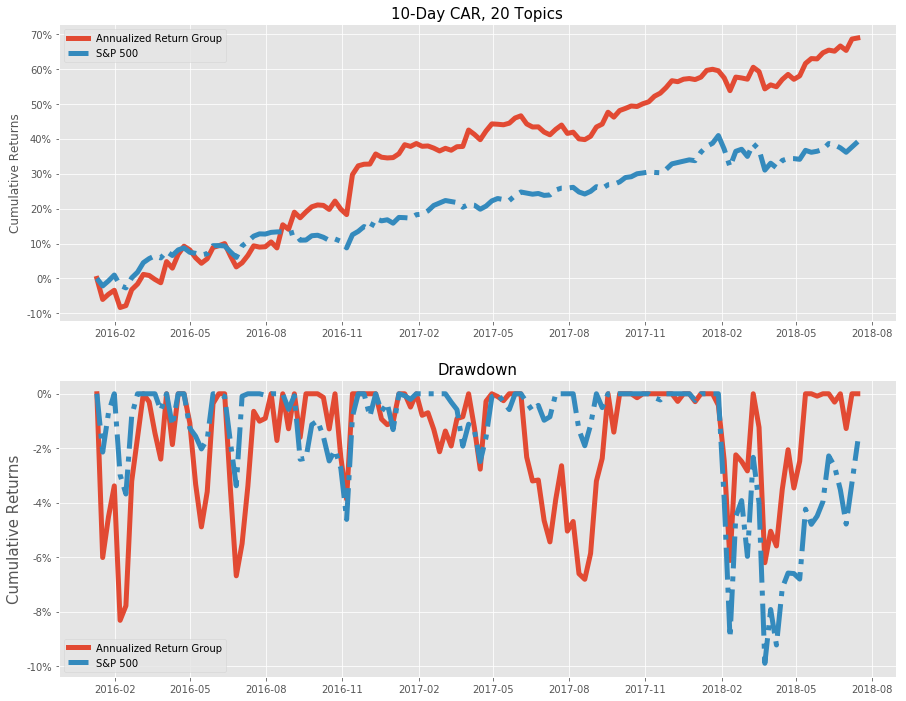

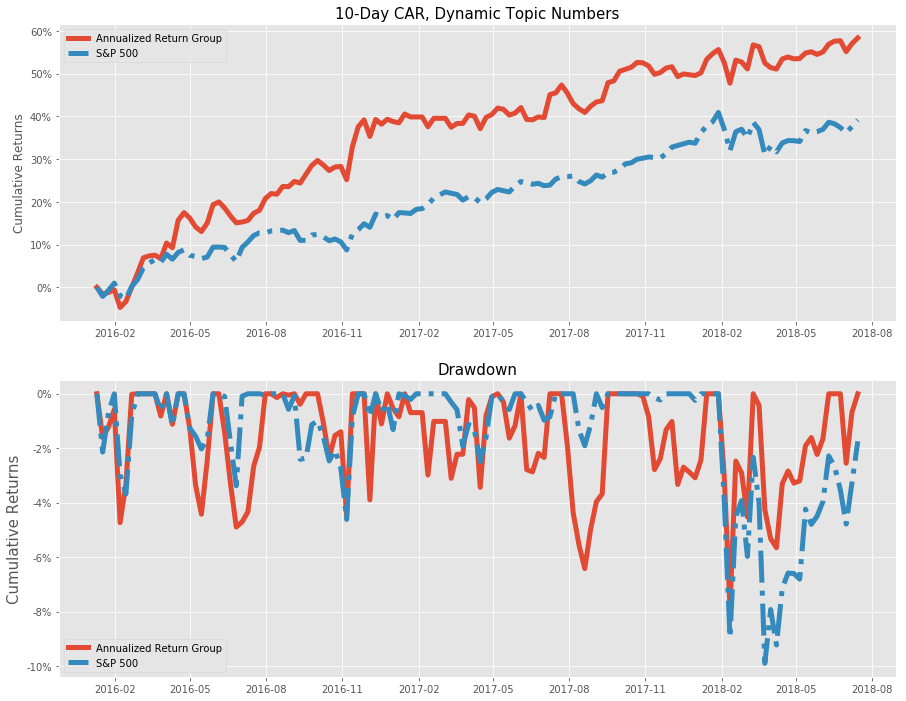

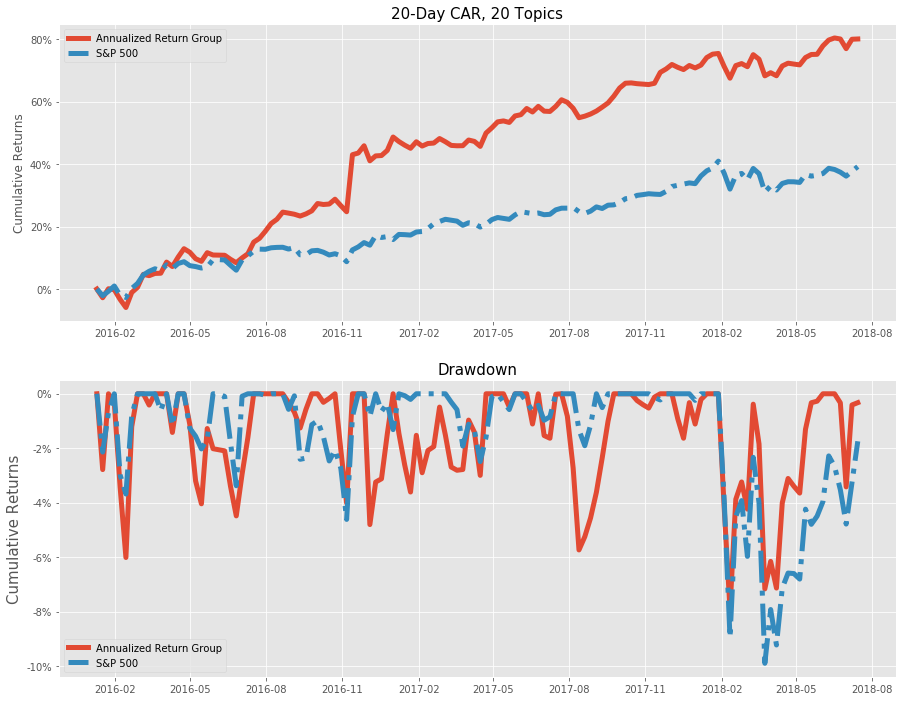

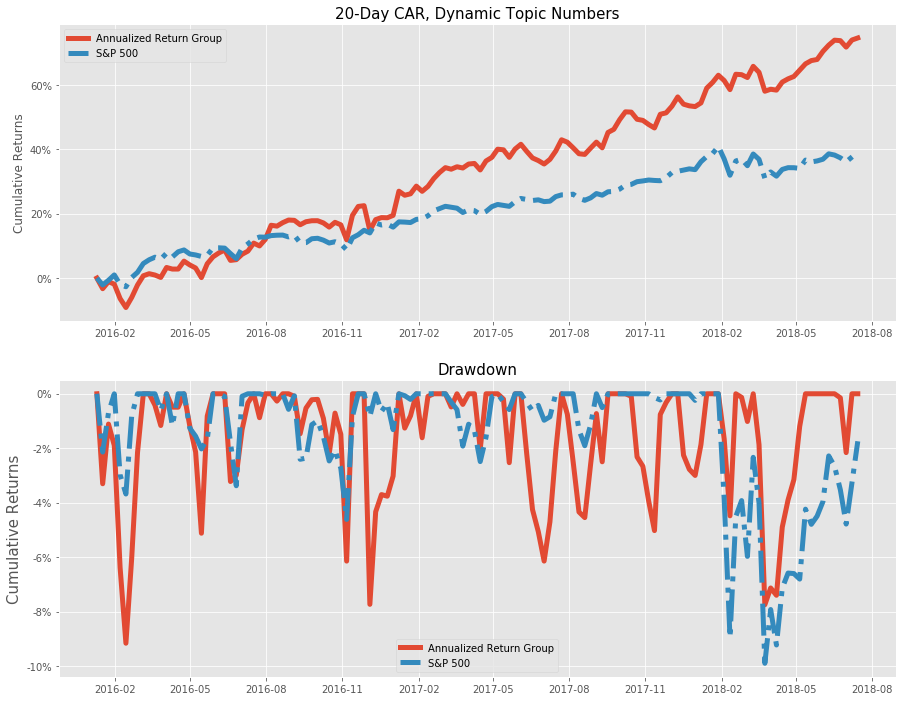

In [76]:
root_dir = 'D:/strategy_results/'
car_topic = [(10,20),(10,30),(20,20),(20,40)]
i = 0
for car_num,topic_num in car_topic:
    if i == 1  or i == 3:
        single_plotting(root_dir,car_num,topic_num,idx,mm,title_topic=False)
    else:
        single_plotting(root_dir,car_num,topic_num,idx,mm,title_topic=True)
    i+=1
        

In [78]:
def multi_plotting(root_dir,car_num,topic_num,idx,mm,title_topic = True):
    factor_1 = 'Annualized Returns'
    factor_2 = 'Jensen Alpha'
    factor_3 = 'Sharpe Ratio'
    factor_4 = 'Information Ratio'
    
    factor_list = [factor_1,factor_2,factor_3,factor_4]
    ss_list = []
    
    for factor in factor_list:

        fn = filename_k(root_dir,car_num,topic_num,factor)
        df = pd.read_csv(fn)
        ss =  list(df['Average Return'])
        ss = list(df['Average Return'])
        ss.insert(0,0)
        ss = pd.Series(ss)

        shortest = min([len(ss),len(idx),len(mm)])
        ss = ss[:shortest]
        ss_list.append(ss)
        
    idx = idx[:shortest]
    mm = mm[:shortest]
    def to_percent(temp, position):
        return '%1.00f'%(100*temp) + '%'

    from matplotlib.ticker import FuncFormatter
    plt.figure(figsize=(15,6))
    plt.style.use('ggplot')
    for ss in ss_list:
        plt.plot(idx,ss.cumsum(),'-',linewidth=5.0)

    plt.plot(idx,mm.cumsum(),'-.',linewidth=5.0)
    
    factor_all = factor_list+['S&P 500']
    
    plt.legend(factor_all)
    plt.grid(True)
    plt.ylabel('Cumulative Returns')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))
    if title_topic:
        plt.title(str(car_num)+'-Day CAR, '+str(topic_num)+' Topics',fontsize=15)
    else:
        plt.title(str(car_num)+'-Day CAR, '+'Dynamic Topic Numbers',fontsize=15)
        
    
  
    
    plt.show()
    


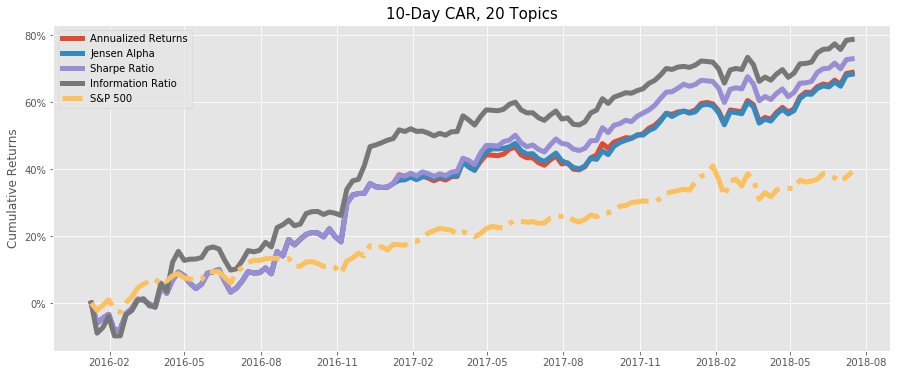

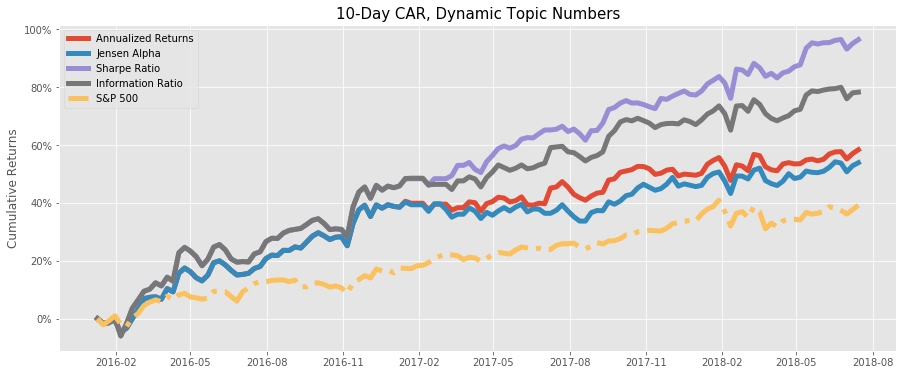

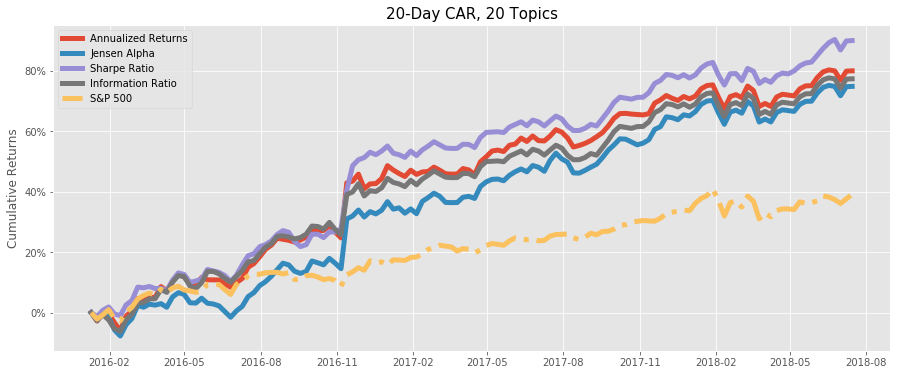

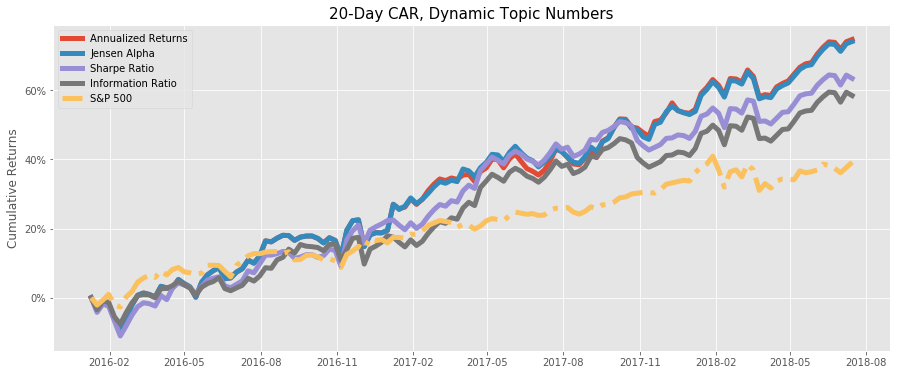

In [79]:
root_dir = 'D:/strategy_results/'
car_topic = [(10,20),(10,30),(20,20),(20,40)]
i = 0
for car_num,topic_num in car_topic:
    if i == 1  or i == 3:
        multi_plotting(root_dir,car_num,topic_num,idx,mm,title_topic=False)
    else:
        multi_plotting(root_dir,car_num,topic_num,idx,mm,title_topic=True)
    i+=1
        

In [87]:
def single_performance(car_num,topic_num,root_dir,mm,factor='Annualized Returns'):

    fn = filename_k(root_dir,car_num,topic_num,factor)
    df = pd.read_csv(fn)
    week_num = df.index
    week_profit = df['Average Return']
    shortest = min([len(week_profit),len(mm)])
    week_profit = week_profit[:shortest]
    mm = mm[:shortest]
    
    performance = pd.DataFrame()
    sum_profit = Sum_profit(week_profit)
    ap = Annual_profit(week_num, sum_profit)
    md = Max_drawdown(week_num, sum_profit)
    wwc = Week_win_chance(week_num,week_profit)
    msc = Max_sequent_weeks(week_num,week_profit)
    vix = VIX(week_profit)
    sr = Sharp_ratio(ap,vix)
    ir = Infromation_ratio(week_profit, mm)
    x = str(1)
    
    X = np.array(mm)
    Y = np.array(week_profit)
    X = X.reshape(-1,)

    X = sm.add_constant(X)
    MODEL= regression.linear_model.OLS(Y, X).fit()
    performance.loc[x,'Factor'] = factor
    performance.loc[x,'CAR'] = car_num
    performance.loc[x,'Topics'] = topic_num
    performance.loc[x,'Annualized Returns'] = ap
    performance.loc[x,'Max Drawdown'] = md
    performance.loc[x,'Sharpe Ratio'] = sr
    performance.loc[x,'Informantion Ratio'] = ir
    
    performance.loc[x,'Jensen Alpha'] = ap - MODEL.params[1]*(np.array(mm).mean()*52)
    performance.loc[x,'Winning Chnace'] = wwc

    dd = drawdown(week_num, sum_profit)
    mm_sum =  Sum_profit(mm)
    dd_m = drawdown(week_num,mm_sum)
    return performance,dd,dd_m
    

In [88]:
car_topic = [(10,20),(10,30),(20,20),(20,40)]
i = 0
a = pd.DataFrame()
factor_list = ['Annualized Returns','Jensen Alpha','Sharpe Ratio','Information ratio']
for factor in factor_list:
    for car_num,topic_num in car_topic:
        p,dd,dd_m = single_performance(car_num,topic_num,root_dir,mm,factor)
        a = pd.concat([a,p],ignore_index=True)
a.to_csv('D:/results_summary.csv')
    